In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### --- Begin Exploratory Sandbox ---

In [10]:
# Use inspect to explore the given data
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types for 'measurement' table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Peek at 'measurement' data
session.query(Measurement.id,
              Measurement.station,
              Measurement.date,
              Measurement.prcp).\
order_by(Measurement.date.desc()).\
limit(100).\
all()

[(2724, 'USC00519397', '2017-08-23', 0.0),
 (7635, 'USC00514830', '2017-08-23', 0.0),
 (12187, 'USC00519523', '2017-08-23', 0.08),
 (19550, 'USC00516128', '2017-08-23', 0.45),
 (2723, 'USC00519397', '2017-08-22', 0.0),
 (12186, 'USC00519523', '2017-08-22', 0.0),
 (19549, 'USC00516128', '2017-08-22', 0.5),
 (2722, 'USC00519397', '2017-08-21', 0.0),
 (7634, 'USC00514830', '2017-08-21', 0.02),
 (12185, 'USC00519523', '2017-08-21', None),
 (19548, 'USC00516128', '2017-08-21', 0.56),
 (2721, 'USC00519397', '2017-08-20', 0.0),
 (7633, 'USC00514830', '2017-08-20', 0.01),
 (19547, 'USC00516128', '2017-08-20', None),
 (2720, 'USC00519397', '2017-08-19', 0.0),
 (7632, 'USC00514830', '2017-08-19', 0.0),
 (12184, 'USC00519523', '2017-08-19', None),
 (19546, 'USC00516128', '2017-08-19', 0.09),
 (2719, 'USC00519397', '2017-08-18', 0.0),
 (7631, 'USC00514830', '2017-08-18', 0.0),
 (14959, 'USC00519281', '2017-08-18', 0.06),
 (19545, 'USC00516128', '2017-08-18', None),
 (7630, 'USC00514830', '2017-08-

In [13]:
# determine 'measurement' record count
session.query(func.count(Measurement.id)).all()

[(19550)]

In [14]:
# Get a list of column names and types for 'station' table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Peek at 'station' data
session.query(Station.id,
              Station.station,
              Station.name,
              Station.latitude,
              Station.longitude,
              Station.elevation).\
limit(50).all()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (7,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (8,
  'USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [16]:
# determine 'station' record count
session.query(func.count(Station.id)).all()

[(9)]

### --- End Exploratory Sandbox ---

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Format date for aggregation.  Retain only year and month
prcp_month = func.strftime("%Y-%m", Measurement.date)

# Query the 'measurement' table, sum 'prcp' by year/month, keep last 12 monthly totals
lastTwelveMonPrcp = session.query(
    prcp_month,
    func.sum(Measurement.prcp)
).\
group_by(prcp_month).\
order_by(prcp_month.desc()).\
limit(12).\
all()

# Confirm query results
lastTwelveMonPrcp

# Create empty lists to store data from the 12 month 'measurement' query
prcp_total = []
prcp_month = []

# Add data to the empty lists
for totalPrcp in range(len(lastTwelveMonPrcp)):
    prcp_month.append(lastTwelveMonPrcp[11-totalPrcp][0])
    prcp_total.append(lastTwelveMonPrcp[11-totalPrcp][1])

# Create a dataframe that matches the lastTwelveMonPrcp object
lastTwelveMonPrcp_df = pd.DataFrame({
    "Month":prcp_month,
    "Precipitation Total":prcp_total
})

# Confirm expected values in dataframe
lastTwelveMonPrcp_df

# Create a bar graph of the vw_salary_range object
#ax = avgSalary_df.plot.bar(x='Position Title',y='Position Mean Annual Salary', color='g',alpha=0.5,align='center')
#ax.set_title('Position Mean Annual Salary (USD)')

# Save an image of the plot


,Month,Precipitation Total
0,2016-09,49.40
1,2016-10,21.77
2,2016-11,20.56
3,2016-12,35.51
4,2017-01,11.95
5,2017-02,39.06
6,2017-03,29.62
7,2017-04,54.91
8,2017-05,25.27
9,2017-06,20.52


Text(0.5, 1.0, 'Monthly Hawaiian Precipitation (Last 12 Months)')

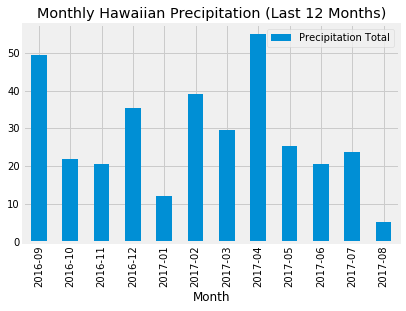

In [30]:
# Create a bar graph
ax = lastTwelveMonPrcp_df.plot.bar(x='Month',y='Precipitation Total')
ax.set_title('Monthly Hawaiian Precipitation (Last 12 Months)')

# Save an image of the plot


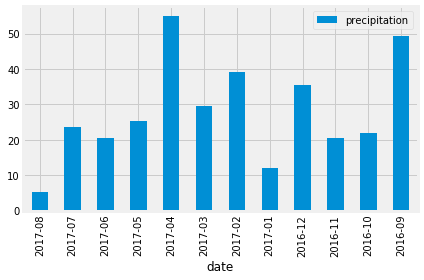

In [20]:
# Plot the Results in a Matplotlib bar chart
df = pd.DataFrame(lastTwelveMonPrcp, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)
df.plot.bar()
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# Save an image of the plot


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Save an image of the histogram

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Save an image of the bar chart

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

# Save an image of the plot